<a href="https://colab.research.google.com/github/arkadijshmelev/Time_series_processing/blob/master/time_series_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [551]:
# Загружаем google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Библиотеки

In [552]:
pip install catboost

In [553]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor
import holidays as hd
import datetime

### Настройки

In [554]:
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

### Данные

In [555]:
holidays_events = pd.read_csv('/content/drive/MyDrive/Data_for_time_series/holidays_events.csv')
items = pd.read_csv('/content/drive/MyDrive/Data_for_time_series/items.csv')
stores = pd.read_csv('/content/drive/MyDrive/Data_for_time_series/stores.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Data_for_time_series/transactions.csv')
train = pd.read_csv('/content/drive/MyDrive/Data_for_time_series/train.csv', nrows=7000000)

In [556]:
display(train.head())
train.shape

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


(7000000, 6)

In [557]:
# Групируем данные.
group_train = train.groupby('date')['unit_sales'].sum()
# Переводим серию в dataframe.
group_train = group_train.to_frame(name='sales')
# Переводим индех в datetime.
group_train.index = pd.to_datetime(group_train.index)

In [558]:
group_train.head()

,sales
date,
2013-01-01,2511.619
2013-01-02,496092.418
2013-01-03,361429.231
2013-01-04,354459.677
2013-01-05,477350.121


In [559]:
print('Количество элементов в таблице -', group_train.shape[0])

Количество элементов в таблице - 166


### Сезонная декомпозиция

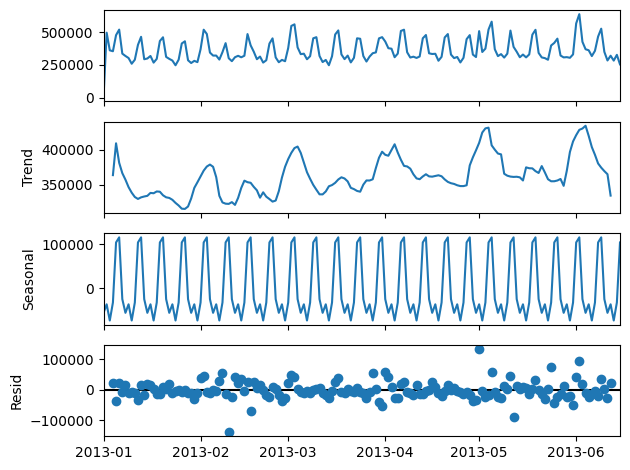

In [560]:
decomposition = seasonal_decompose(group_train, model='additive');
decomposition.plot();

In [561]:
trend_part = decomposition.trend # трендовая составляющаяя
seasonal_part = decomposition.seasonal # сезонная составляющаяя
residual_part = decomposition.resid # шум

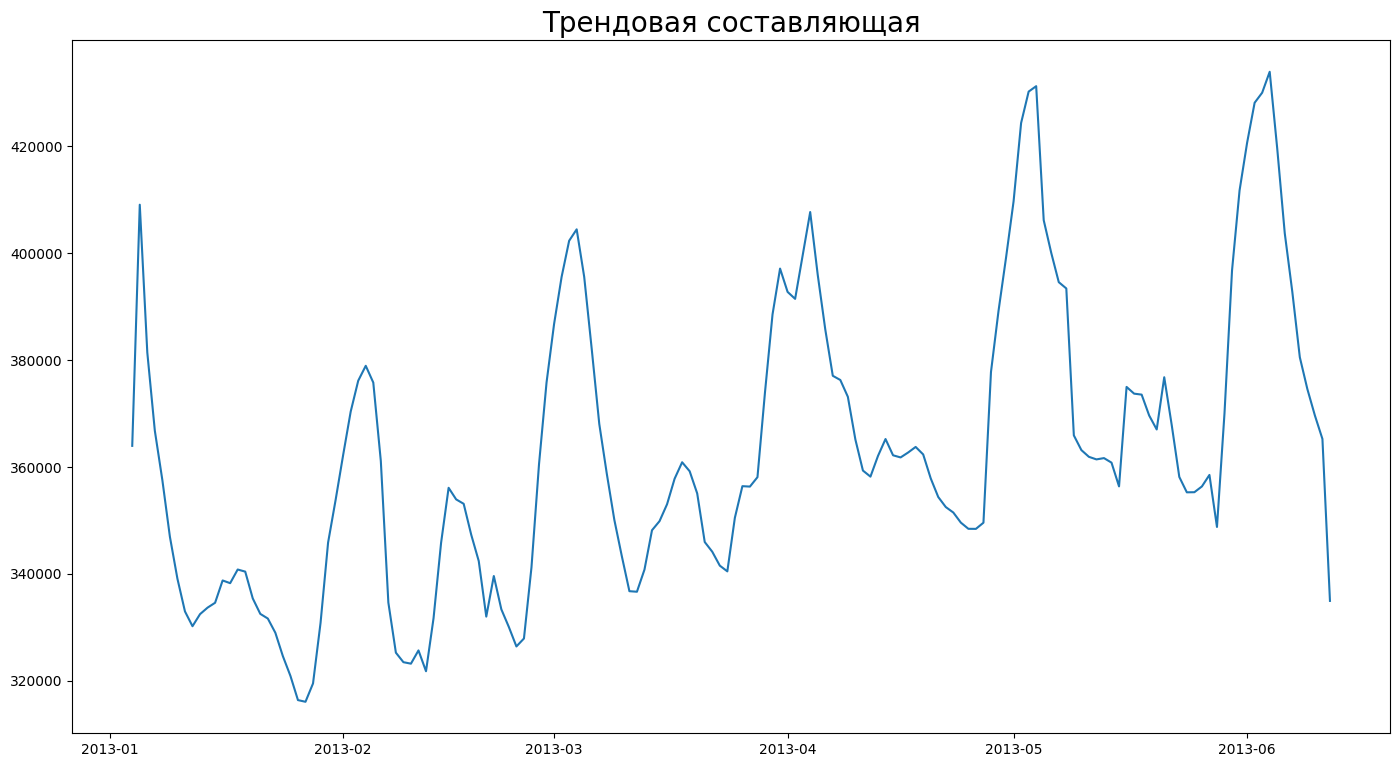

In [562]:
# Посмотрим по ближе на трендовую составляющую.
fig = plt.figure(figsize=(17, 9));
plt.plot(trend_part);
plt.title('Трендовая составляющая', size=20);

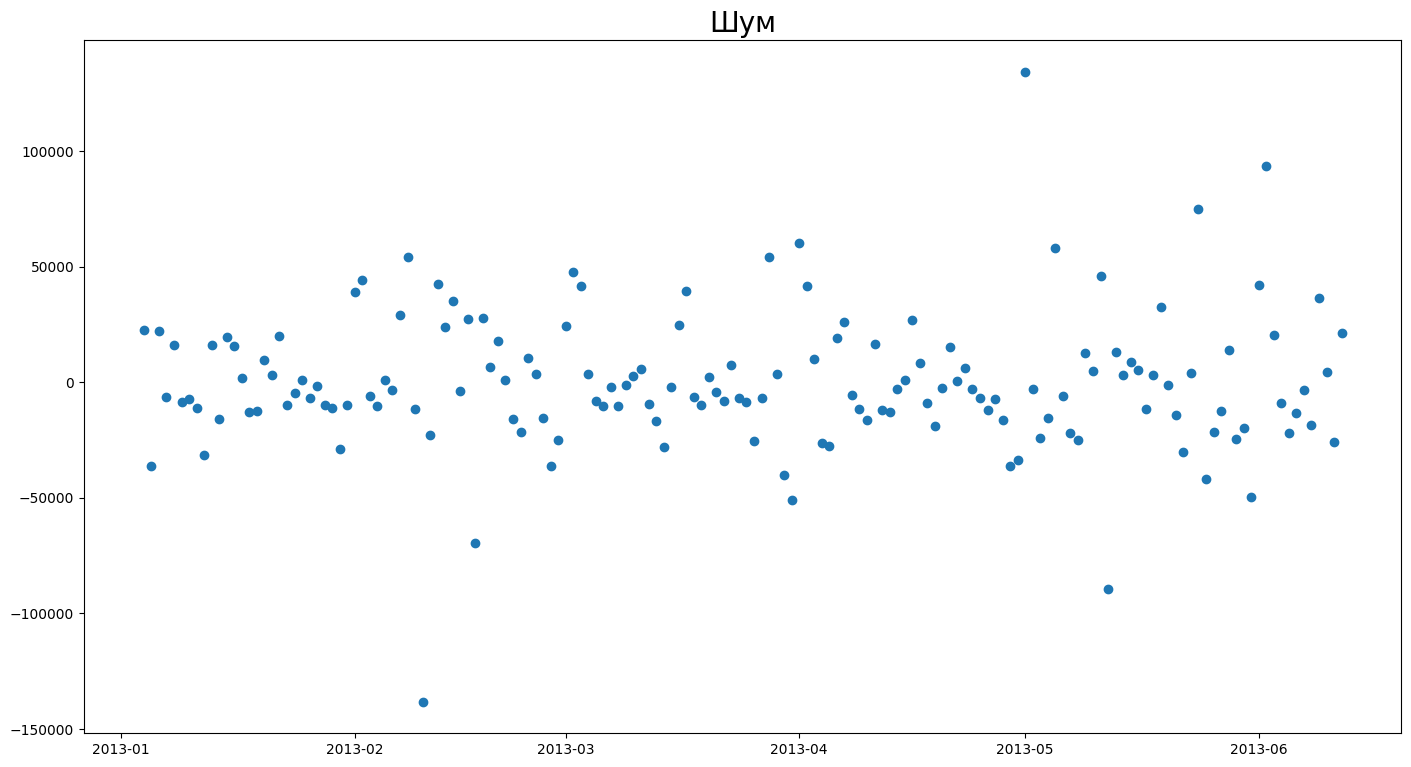

In [563]:
# Посмотрим по ближе на шум.
fig = plt.figure(figsize=(17, 9));
plt.scatter(x=residual_part.index, y=residual_part.values);
plt.title('Шум', size=20);

Анализ результата:

В ряде слабо виден возрастающий тренд, и ярко выражена сезонность и цикличность.

В остатках наблюдается закономерность похожая на пики (^^^^^^^^^).

In [564]:
print('Количество элементов в шумовой части -', residual_part.shape[0])
print('Количество числовых элементов в шумовой части -', residual_part[residual_part.values != None].count())
print('Количество пропущенных значений в шумовой части -', residual_part.isnull().sum())
print('Количество элементов в сезонной части -', seasonal_part.shape[0])
print('Количество элементов в трендовой части', trend_part.shape[0])

Количество элементов в шумовой части - 166
Количество числовых элементов в шумовой части - 160
Количество пропущенных значений в шумовой части - 6
Количество элементов в сезонной части - 166
Количество элементов в трендовой части 166


In [565]:
# Удалим пропущенные значения из шумовой части.
residual_part.dropna(inplace=True)
print('Количество пропущенных значений в шумовой части -', residual_part.isnull().sum())

Количество пропущенных значений в шумовой части - 0


###  Тест Дики-Фуллера

In [566]:
test = adfuller(group_train['sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0] > test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда
    print ('Ряд не стационарен.')
else:
    print ('Ряд стационарен.')

adf:  -2.535619341346662
p-value:  0.10704649763465768
Critical values:  {'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494}
Ряд не стационарен.


Визуальное обнаружение нестационарности ряда подтвердил тест Дики-Фуллера.

### Кросс-валидация для временных рядов

In [567]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(group_train['sales'])
for train_index, test_index in train_test_groups:
    print('Размер тренировочного набора :', len(train_index), 'Размер тестового набора :', len(test_index))

Размер тренировочного набора : 145 Размер тестового набора : 7
Размер тренировочного набора : 152 Размер тестового набора : 7
Размер тренировочного набора : 159 Размер тестового набора : 7


### Формирование признаков для временного ряда

In [568]:
# Построим скользящее среднее.
group_train['mean_sales'] = group_train['sales'].rolling(window=5).mean()
# Построим скользящее квадратичное отклонение.
group_train['std_sales'] = group_train['sales'].rolling(window=5).std()
# Построим полосы Боллинджера.
group_train['upper'] = group_train['mean_sales'] + 3 * group_train['std_sales']
group_train['lower'] = group_train['mean_sales'] - 3 * group_train['std_sales']

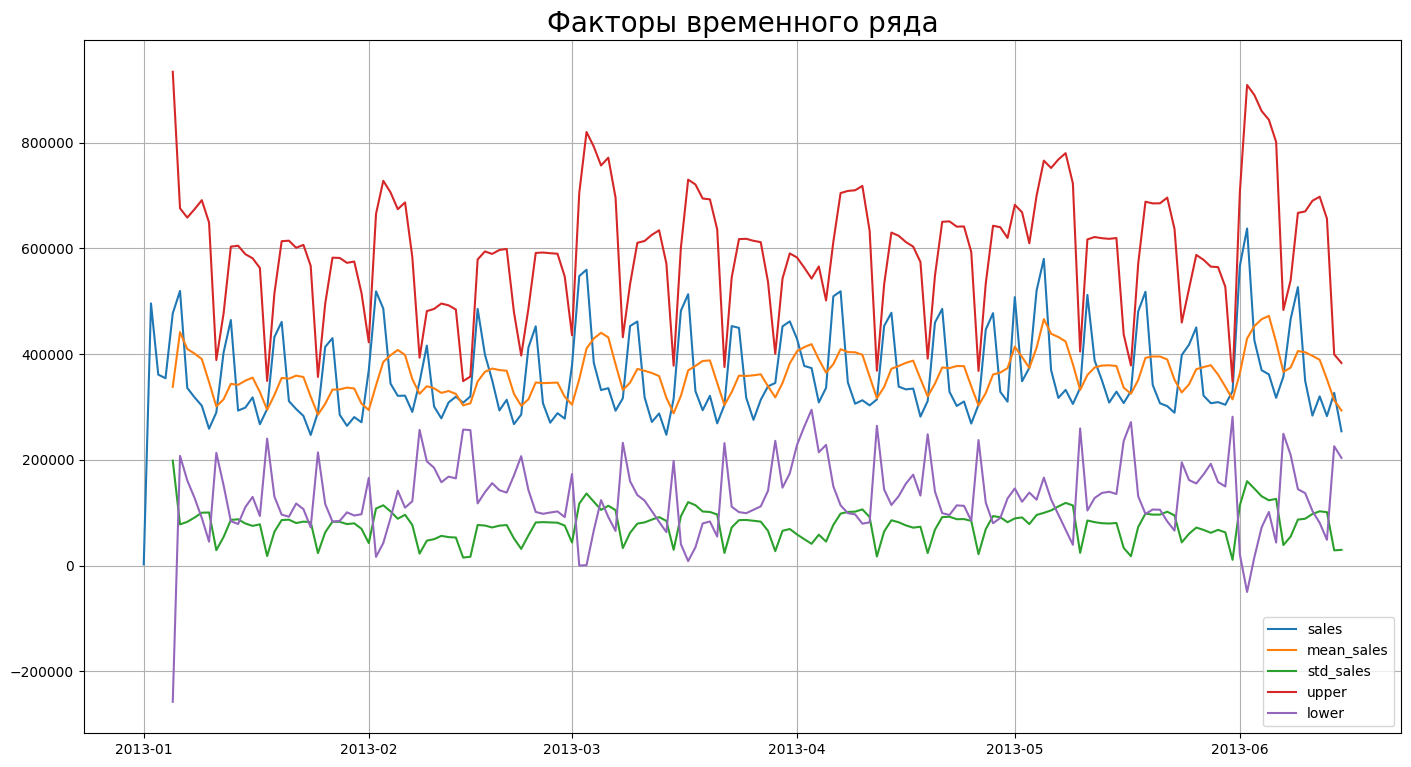

In [569]:
fig = plt.figure(figsize=(17, 9))
plt.plot(group_train);
plt.legend(['sales', 'mean_sales', 'std_sales', 'upper', 'lower']);
plt.title('Факторы временного ряда', size=20)
plt.grid();

In [570]:
# Построим среднее и экспоненциальное среднее.
group_train['mean'] = group_train['sales'].rolling(window=10).mean()
group_train['ewm'] = group_train['sales'].ewm(min_periods=7, span=7).mean()


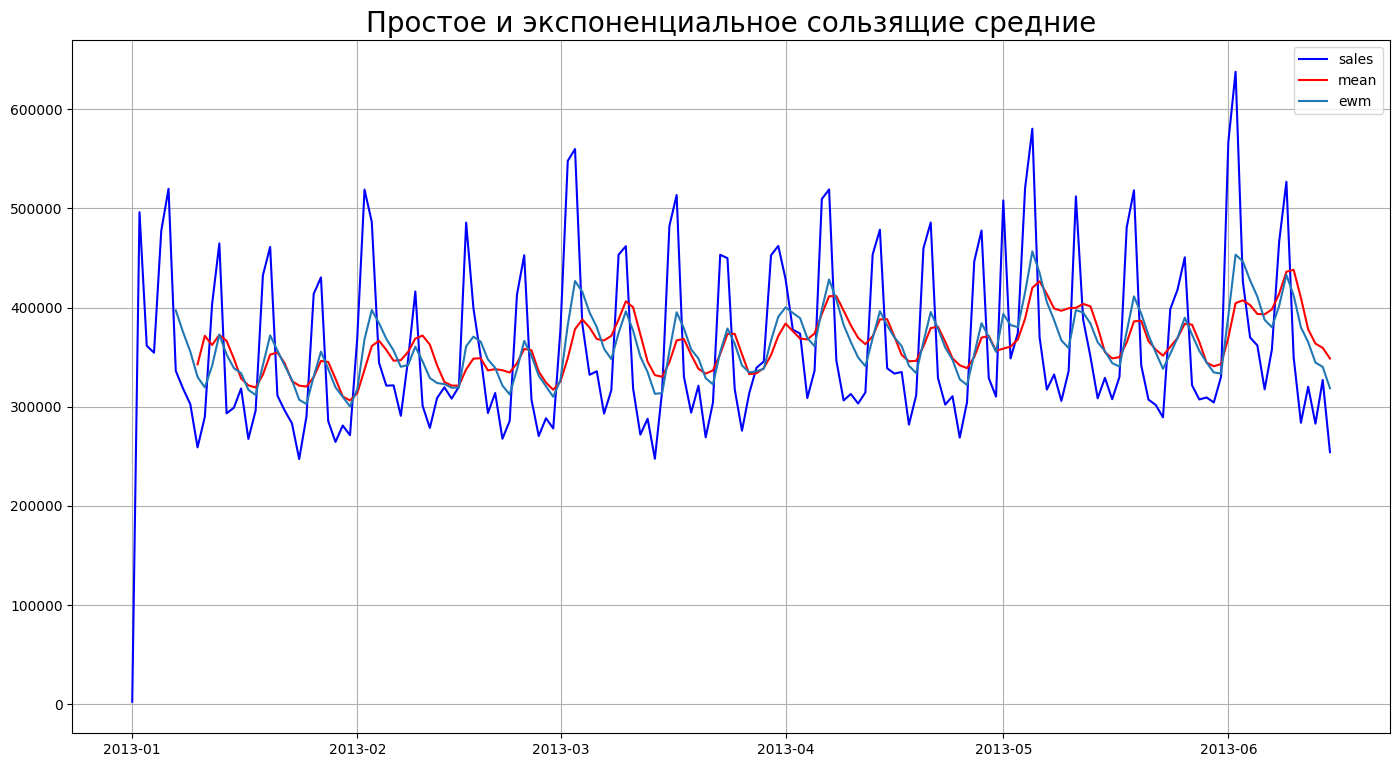

In [571]:
fig = plt.figure(figsize=(17, 9))
plt.plot(group_train['sales'], c='b')
plt.plot(group_train['mean'], c='r')
plt.plot(group_train['ewm'], )
plt.legend(['sales', 'mean', 'ewm'])
plt.title('Простое и экспоненциальное сользящие средние', size=20)
plt.grid();

In [572]:
def unit_sales(value):
  '''Функция считает среднее арифметическое между максимальным и минимальным значением.'''
  return (value.max() - value.min()) / len(value)

In [573]:
group_train['unit_sales']  = group_train['sales'].rolling(window=10).apply(unit_sales, raw=False)

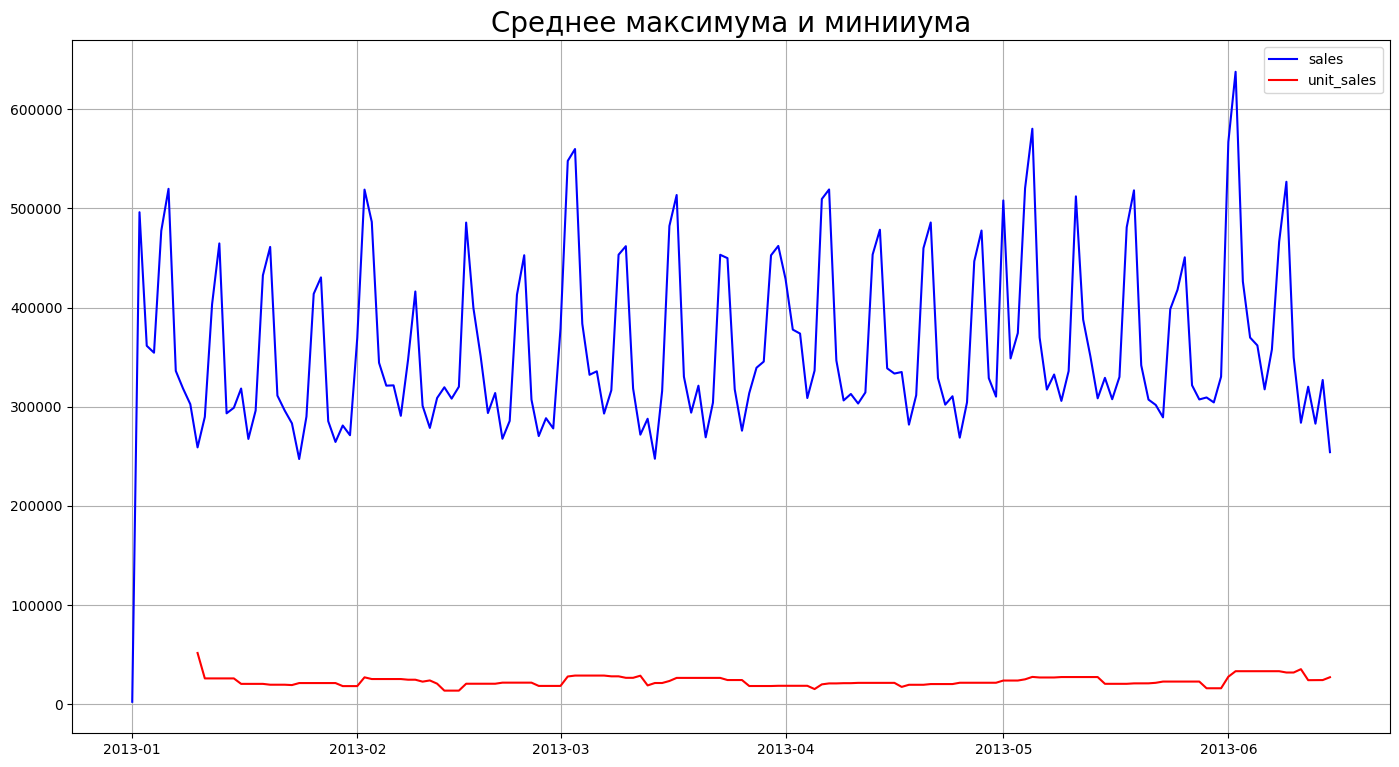

In [574]:
fig = plt.figure(figsize=(17, 9))
plt.plot(group_train['sales'], c='b')
plt.plot(group_train['unit_sales'], c='r')
plt.legend(['sales', 'unit_sales'])
plt.title('Среднее максимума и минииума', size=20)
plt.grid();

In [575]:
# Построим среднее и экспоненциальное среднее.
group_train['mean_50'] = group_train['sales'].rolling(window=50).mean()
group_train['ewm_10'] = group_train['sales'].ewm(min_periods=10, span=10).mean()
group_train['subtraction'] = group_train['mean_50'] - group_train['ewm_10']

In [576]:
group_train['sign'] = np.sign(group_train['subtraction'])
group_train['diff_sign'] = group_train['sign'].diff().dropna()
group_train_dropna = group_train.dropna()

# Найдем индексы точек пересечения скользящих средних.
intersection_points = group_train_dropna[group_train_dropna['diff_sign'] != 0].index
print(intersection_points)

DatetimeIndex(['2013-02-20', '2013-02-24', '2013-02-26', '2013-03-02',
               '2013-03-13', '2013-03-16', '2013-03-20', '2013-03-24',
               '2013-03-26', '2013-03-30', '2013-04-11', '2013-04-13',
               '2013-04-17', '2013-04-21', '2013-04-24', '2013-04-28',
               '2013-04-30', '2013-05-01', '2013-05-10', '2013-05-11',
               '2013-05-14', '2013-05-19', '2013-05-21', '2013-05-26',
               '2013-05-28', '2013-06-01', '2013-06-12'],
              dtype='datetime64[ns]', name='date', freq=None)


In [577]:
# Получите лаговые факторы с 7-го по 10-й предыдущих дней.
for i in range(7, 11):
  group_train[f'lag_{i}'] = group_train['sales'].shift(i)

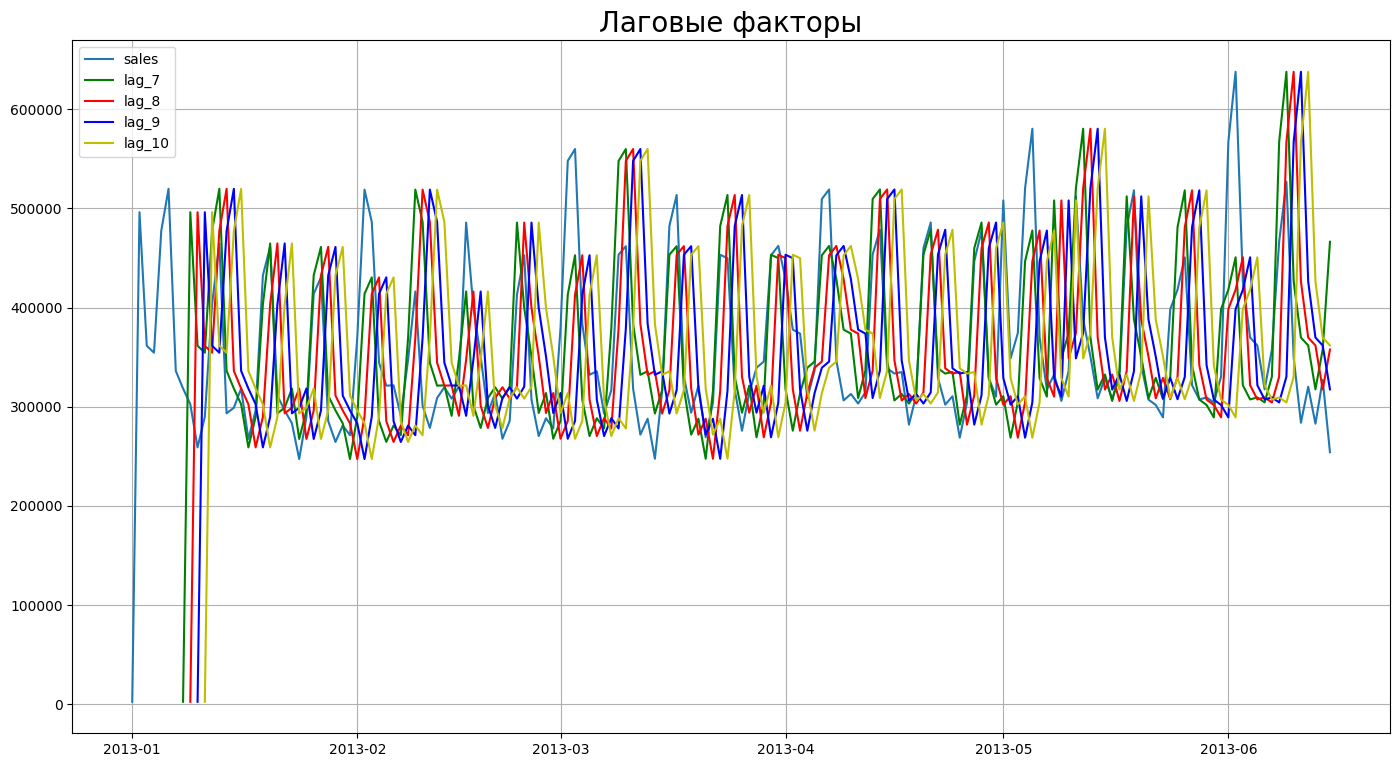

In [578]:
fig = plt.figure(figsize=(17, 9))
plt.plot(group_train['sales'])
plt.plot(group_train['lag_7'],  c='g')
plt.plot(group_train['lag_8'],  c='r')
plt.plot(group_train['lag_9'],  c='b')
plt.plot(group_train['lag_10'],  c='y')
plt.legend(['sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
plt.title('Лаговые факторы', size=20)
plt.grid();

In [579]:
# Оставим продукт определенного номера.
arima_train = train[train['item_nbr'] == 103501]

In [580]:
# Групируем данные.
arima_train = arima_train.groupby('date')['unit_sales'].sum()
# Переводим серию в dataframe.
arima_train = arima_train.to_frame(name='sales')
# Переводим индех в datetime.
arima_train.index = pd.to_datetime(arima_train.index)

In [581]:
display(arima_train.head())
print(arima_train.shape)

,sales
date,
2013-01-02,185.0
2013-01-03,153.0
2013-01-04,155.0
2013-01-05,160.0
2013-01-06,173.0


(165, 1)


Проверим ряд на стационарность

In [582]:
test = adfuller(arima_train['sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0] > test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда
    print ('Ряд не стационарен.')
else:
    print ('Ряд стационарен.')

adf:  -3.4442974672424884
p-value:  0.00953833682812579
Critical values:  {'1%': -3.474714913481481, '5%': -2.881008708148148, '10%': -2.5771508444444446}
Ряд стационарен.


### Модель скользящего среднего

In [583]:
def moving_average_forecast(data, window_size):

    forecast = []

    for time in range(len(data) - window_size):
        forecast.append(data[time:time + window_size].mean())

    return np.array(forecast)

moving_average_days = 6

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(arima_train, moving_average_days )
moving_avg = [a for b in moving_avg for a in b]
moving_avg = pd.Series(moving_avg, index = arima_train[moving_average_days:].index)

In [584]:
print(moving_avg[-moving_average_days:].shape, arima_train[-moving_average_days:].shape)
print('MSE', mean_squared_error(arima_train.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print('MAE', mean_absolute_error(arima_train.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print('MAPE', mean_absolute_percentage_error(arima_train.values[-moving_average_days:], moving_avg[-moving_average_days:]))

(6,) (6, 1)
MSE 606.5370370370371
MAE 21.166666666666668
MAPE 0.26618249362800966


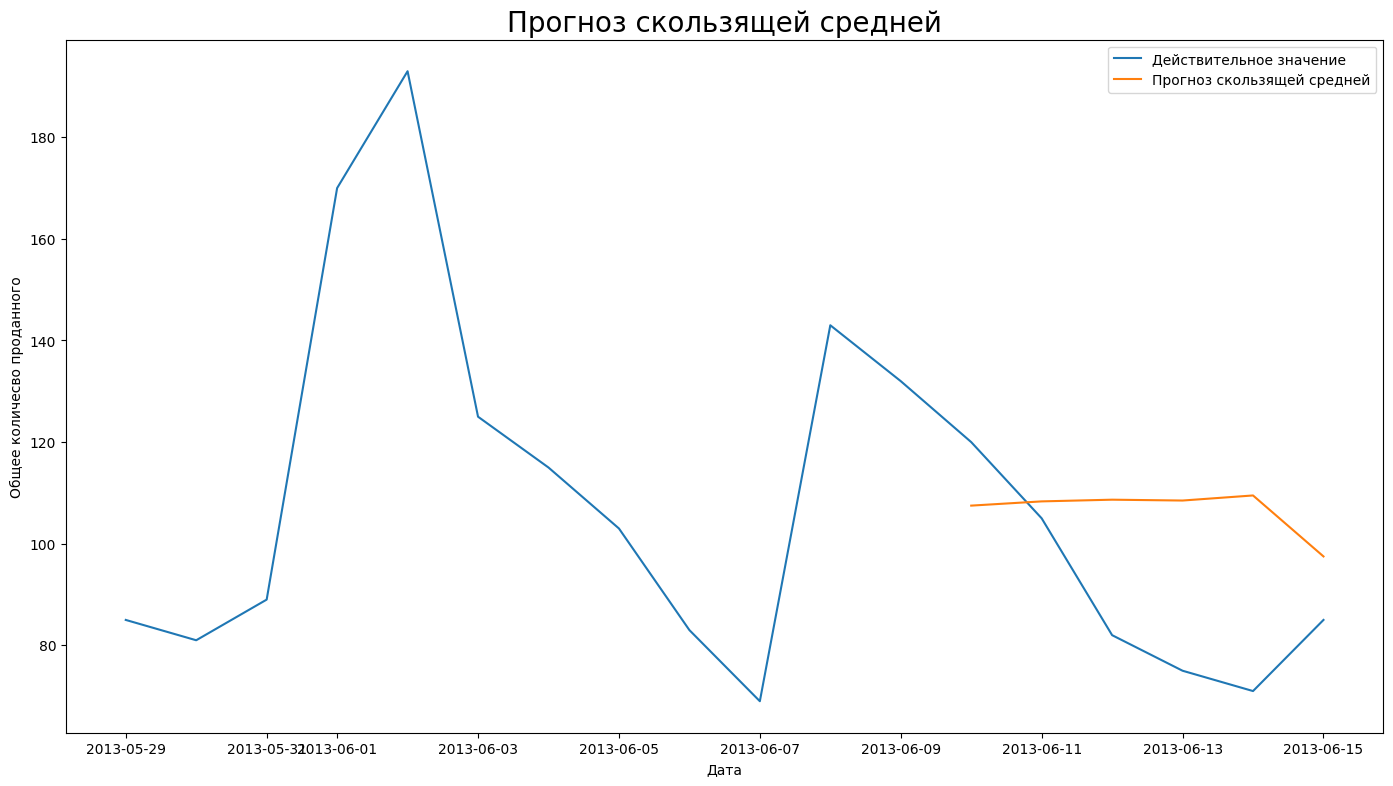

In [585]:
plt.figure(figsize=(17, 9))
plt.plot(arima_train[- shown_train_size:], label='Действительное значение')
plt.plot(moving_avg[-moving_average_days:], label='Прогноз скользящей средней')
plt.ylabel('Общее количесво проданного')
plt.xlabel('Дата')
plt.title('Прогноз скользящей средней', size=20)
plt.legend(loc='upper right');

In [586]:
# Будем предсказывать 2 дня.
predict_size = 2
# Получите лаговые факторы с 1-го по 6-й предыдущих дней.
for i in range(1, 7):
  arima_train[f'lag_{i}'] = arima_train['sales'].shift(i)

arima_train.dropna(inplace=True)

In [587]:
# Разделим данные на тренировочную и тестовую выборки.
X_train, y_train = arima_train[:-predict_size].drop(['sales'], axis=1), arima_train[:-predict_size]['sales']
X_test, y_test  = arima_train[-predict_size:].drop(['sales'], axis=1), arima_train[-predict_size:]['sales']

In [588]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

LinearRegression()

In [589]:
# Выведем коэффициенты и независимый член.
print(linreg_model.coef_)
print(linreg_model.intercept_)

[ 0.59862113 -0.28463708 -0.00185822 -0.0087091  -0.25168016  0.26428798]
75.45508949647484


In [590]:
# Сделаем предсказание.
pred = pd.Series(linreg_model.predict(X_test), index=X_test.index)
pred

date
2013-06-14    100.342630
2013-06-15    100.226974
dtype: float64

In [591]:
print('MSE', mean_squared_error(y_test, pred))
print('MAE', mean_absolute_error(y_test, pred))
print('MAPE', mean_absolute_percentage_error(y_test, pred))

MSE 546.4253288169826
MAE 22.284801925919304
MAPE 0.29620867343324425


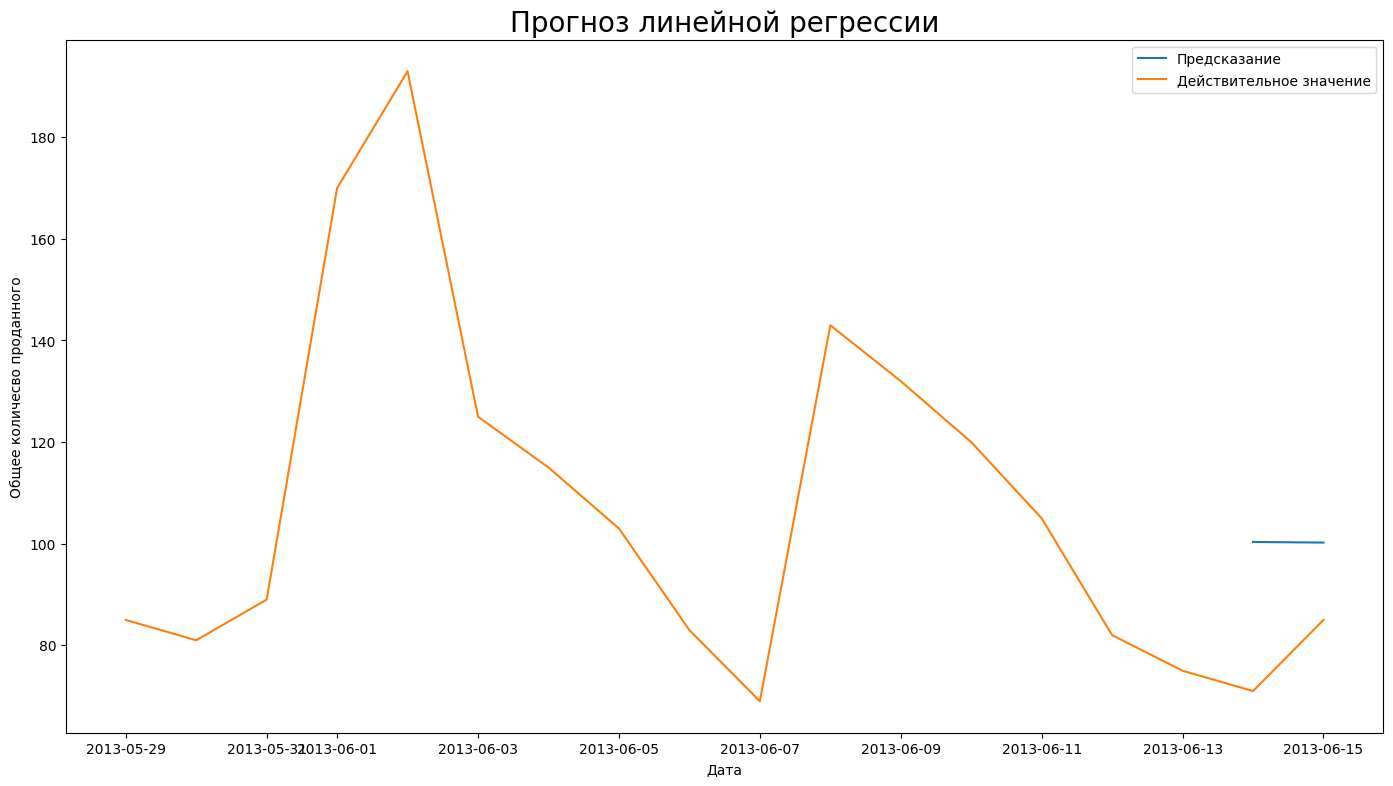

In [592]:
plt.figure(figsize=(17, 9))
plt.plot(pred , label='Предсказание')
plt.plot(pd.concat([y_train, y_test], axis=0)[-shown_train_size:], label='Действительное значение')
plt.xlabel('Дата')
plt.ylabel('Общее количесво проданного')
plt.title('Прогноз линейной регрессии', size=20)
plt.legend(loc='upper right');

### Парметры для модели ARIMA

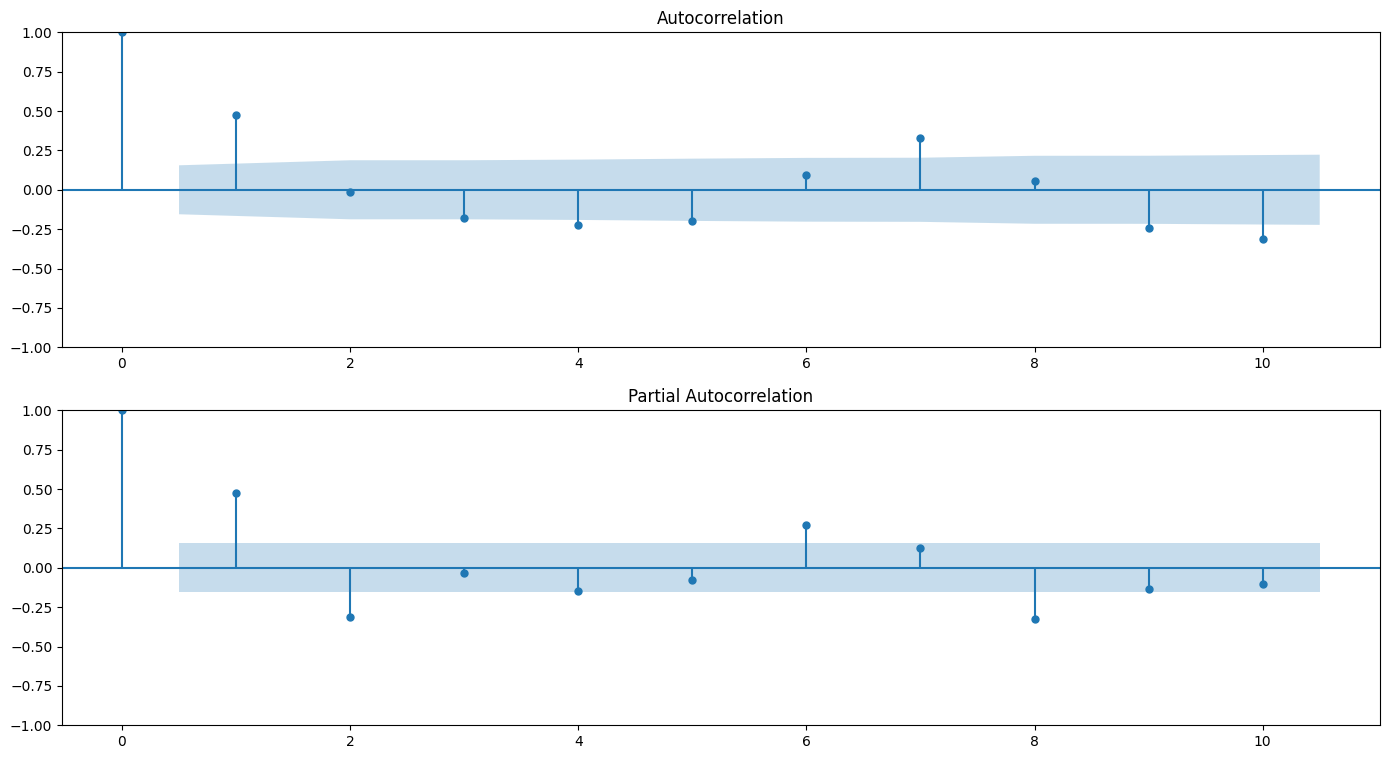

In [593]:
fig = plt.figure(figsize=(17, 9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_train['sales'], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_train['sales'], lags=10, ax=ax2)

p = 2

q = 1

### Модель ARIMA

In [594]:
arima_model = ARIMA(y_train.values.reshape(-1), order=(2,0,1))
train_size = len(y_train)
test_size = predict_size
arima_predictions = arima_model.fit().predict(start=train_size,end=train_size+test_size -1,  dynamic=False)

In [595]:
print('MSE', mean_squared_error(y_test, arima_predictions))
print('MAE', mean_absolute_error(y_test, arima_predictions))
print('MAPE', mean_absolute_percentage_error(y_test, arima_predictions))

MSE 766.218109043913
MAE 27.640550134525206
MAPE 0.3555157607078952


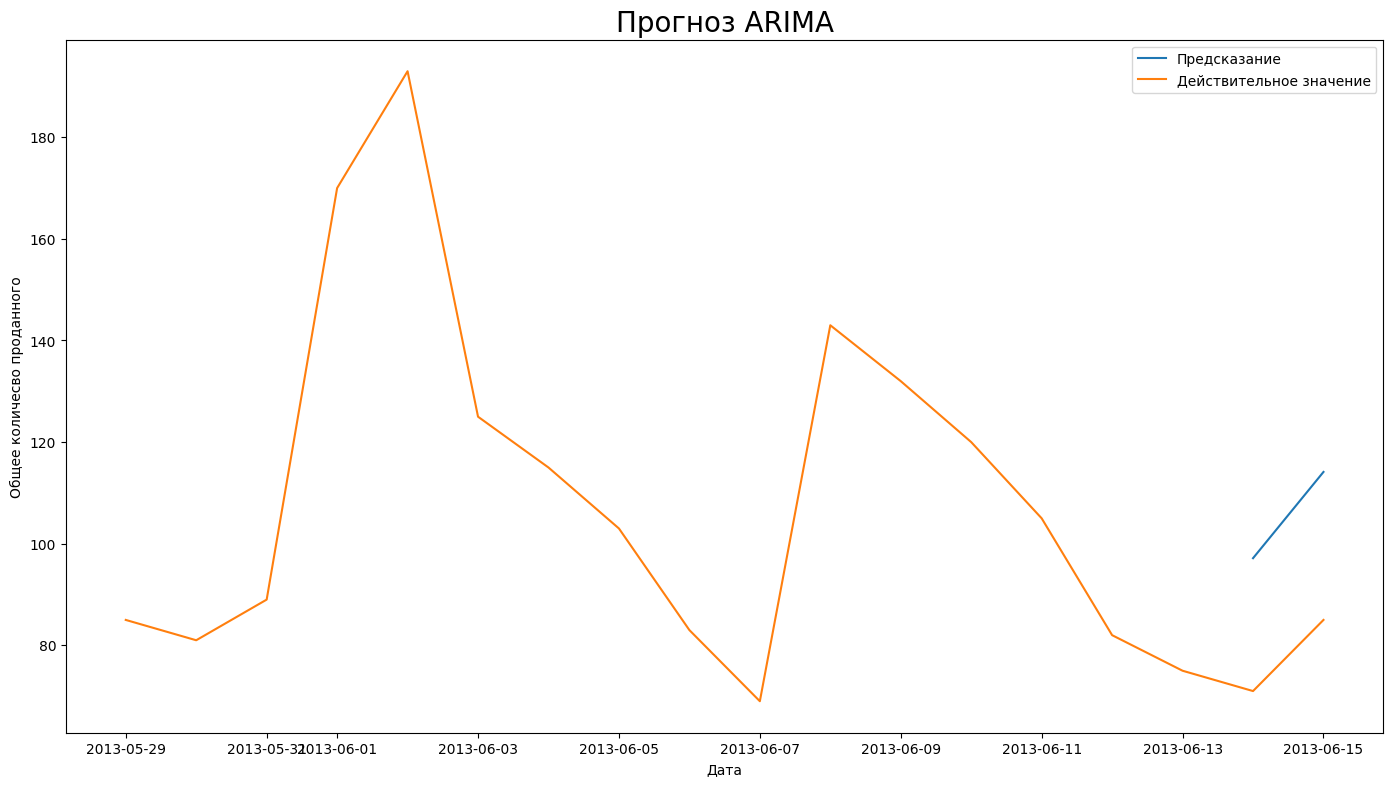

In [596]:
fig = plt.figure(figsize=(17, 9))
plt.plot(pd.Series(arima_predictions, index=y_test.index), label='Предсказание')
plt.plot(pd.concat([y_train, y_test], axis=0)[-shown_train_size:] ,label='Действительное значение')
plt.xlabel('Дата')
plt.ylabel('Общее количесво проданного')
plt.title('Прогноз ARIMA', size=20)
plt.legend(loc='upper right');

Вывод:

Для моделей линейной регрессии и скользящего среднего метрики практически одинаковы. Предсказательная способность отсутствует.

У модели ARIMA метрики хуже, но она правильно определила направление графика.

### Модель FPProphet

In [597]:
# Групируем данные.
prophet_train = train.groupby('date')['unit_sales'].sum()

In [598]:
py.iplot([go.Scatter(
    x=prophet_train.index,
    y=prophet_train
)])

In [599]:
# Приведем данные к необходимому формату.
prophet_train = pd.DataFrame(prophet_train).reset_index()
prophet_train.columns = ['ds', 'y']
display(prophet_train.head())

,ds,y
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121


In [600]:
m = Prophet()
m.fit(prophet_train)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
display(forecast.head())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/zt96hkdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/cmrce45x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97735', 'data', 'file=/tmp/tmp6hj7xdbl/zt96hkdq.json', 'init=/tmp/tmp6hj7xdbl/cmrce45x.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_modela94xos70/prophet_model-20230830164136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,340210.871686,209546.481525,335511.482004,340210.871686,340210.871686,-65952.572822,-65952.572822,-65952.572822,-65952.572822,-65952.572822,-65952.572822,0.0,0.0,0.0,274258.298864
1,2013-01-02,340464.188330,246404.782636,372933.700811,340464.188330,340464.188330,-28473.533076,-28473.533076,-28473.533076,-28473.533076,-28473.533076,-28473.533076,0.0,0.0,0.0,311990.655254
2,2013-01-03,340717.504975,213386.465662,339119.949245,340717.504975,340717.504975,-68689.055690,-68689.055690,-68689.055690,-68689.055690,-68689.055690,-68689.055690,0.0,0.0,0.0,272028.449285
3,2013-01-04,340970.821620,247021.949543,372204.043060,340970.821620,340970.821620,-30815.622370,-30815.622370,-30815.622370,-30815.622370,-30815.622370,-30815.622370,0.0,0.0,0.0,310155.199250
4,2013-01-05,341224.138265,372954.584698,506748.923183,341224.138265,341224.138265,98236.169888,98236.169888,98236.169888,98236.169888,98236.169888,98236.169888,0.0,0.0,0.0,439460.308153


In [601]:
py.iplot([
    go.Scatter(x=prophet_train['ds'], y=prophet_train['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

In [602]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:160, 'yhat']-prophet_train['y'])**2)))

RMSE: 47571.817677


In [603]:
ls = [0.1, 0.3, 0.5, 0.7, 1]
for n in ls:
  m = Prophet(changepoint_prior_scale=n)
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.fit(prophet_train)
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)
  # Вычислим среднеквадратичную ошибку.
  print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:160, 'yhat']-prophet_train['y'])**2)) )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/suvutdj4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/3n52l0tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44019', 'data', 'file=/tmp/tmp6hj7xdbl/suvutdj4.json', 'init=/tmp/tmp6hj7xdbl/3n52l0tx.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_model7cf6z3k0/prophet_model-20230830164137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

RMSE: 40301.044401


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/h6twaiah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/jq697w_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75541', 'data', 'file=/tmp/tmp6hj7xdbl/h6twaiah.json', 'init=/tmp/tmp6hj7xdbl/jq697w_2.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_modelxeb5ot1u/prophet_model-20230830164138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 40279.076416


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/z0p15sfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/aks0uxyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13065', 'data', 'file=/tmp/tmp6hj7xdbl/z0p15sfa.json', 'init=/tmp/tmp6hj7xdbl/aks0uxyv.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_modelq0xe1bjn/prophet_model-20230830164138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 40219.932516


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/8jz8n6lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/tq3kozjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41390', 'data', 'file=/tmp/tmp6hj7xdbl/8jz8n6lc.json', 'init=/tmp/tmp6hj7xdbl/tq3kozjz.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_model04nugc5l/prophet_model-20230830164138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 40181.344346
RMSE: 39739.648914


In [604]:
m = Prophet(changepoint_prior_scale=1)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(prophet_train)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:160, 'yhat']-prophet_train['y'])**2)) )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/1k3tsd46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/8md9jt53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37198', 'data', 'file=/tmp/tmp6hj7xdbl/1k3tsd46.json', 'init=/tmp/tmp6hj7xdbl/8md9jt53.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_model8klgl5qd/prophet_model-20230830164138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 39739.648914


In [605]:
py.iplot([
    go.Scatter(x=prophet_train['ds'], y=prophet_train['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

In [606]:
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Data_for_time_series/holidays_events.csv')
display(df_holidays_events.head())

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [607]:
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
display(holidays.head())

,holiday,ds
0,Fundacion de Manta,2012-03-02
1,Provincializacion de Cotopaxi,2012-04-01
2,Fundacion de Cuenca,2012-04-12
3,Cantonizacion de Libertad,2012-04-14
4,Cantonizacion de Riobamba,2012-04-21


In [608]:
m = Prophet(changepoint_prior_scale=1, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(prophet_train)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/wpyqnbvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hj7xdbl/nkas16wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58391', 'data', 'file=/tmp/tmp6hj7xdbl/wpyqnbvp.json', 'init=/tmp/tmp6hj7xdbl/nkas16wq.json', 'output', 'file=/tmp/tmp6hj7xdbl/prophet_modelcavq40r5/prophet_model-20230830164139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [609]:
# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:160, 'yhat']-prophet_train['y'])**2)) )

RMSE: 23340.956311


In [610]:
py.iplot([
    go.Scatter(x=prophet_train['ds'], y=prophet_train['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

Получилось увеличить метрику.

### Прогнозирование временных рядов с использованием XGBoost

In [611]:
# Групируем данные.
xgb_df = train.groupby('date')['unit_sales'].sum()
# Переводим серию в dataframe.
xgb_df = xgb_df.to_frame(name='sales')
# Переводим индех в datetime.
xgb_df.index = pd.to_datetime(xgb_df.index)

In [612]:
display(xgb_df.head())
print(xgb_df.shape)

,sales
date,
2013-01-01,2511.619
2013-01-02,496092.418
2013-01-03,361429.231
2013-01-04,354459.677
2013-01-05,477350.121


(166, 1)


In [613]:
# Разобьем на тренировочную и тестовую выборки.
split_date = '2013-04-27'
df_train = xgb_df[xgb_df.index <= split_date]
df_test = xgb_df[xgb_df.index >= split_date]
print(df_train.shape, df_test.shape, sep='\n')

(117, 1)
(50, 1)


In [614]:
df_train.head(), df_test.head()

(                 sales
 date                  
 2013-01-01    2511.619
 2013-01-02  496092.418
 2013-01-03  361429.231
 2013-01-04  354459.677
 2013-01-05  477350.121,
                  sales
 date                  
 2013-04-27  446665.338
 2013-04-28  477623.473
 2013-04-29  328795.874
 2013-04-30  310186.467
 2013-05-01  507974.637)

### Признаки

In [615]:
def create_features(df, label=None):
    """Создаем признаки из datetime индекса."""

    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['dayofyear'] = df['date'].dt.dayofyear

    X = df[['dayofweek','quarter','month', 'dayofmonth',
            'weekofyear', 'dayofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [616]:
X_train, y_train = create_features(df_train, label='sales')
X_test, y_test = create_features(df_test, label='sales')

In [617]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(117, 6) (117,)
(50, 6) (50,)


In [618]:
# Создадим модель XGBRegressor.
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

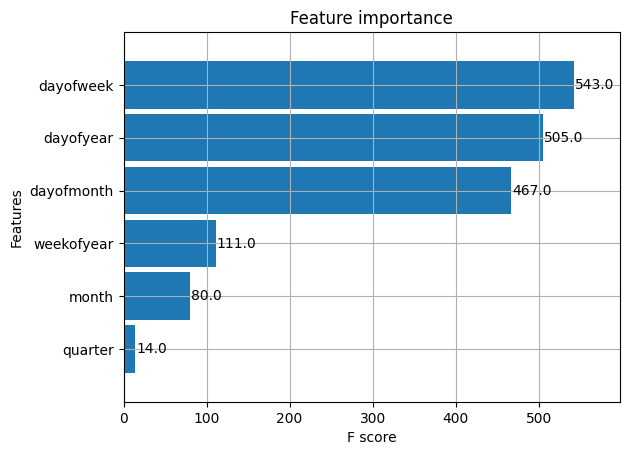

In [619]:
# Выведем важность признаков.
plot_importance(reg, height=0.9);


Мы видим, что день недели, день года и день месяца чаще всего использовался для разделения деревьев, а затем следуют неделя года и месяц. Квартал имеет невысокую важность в связи с тем, что он мог быть создан разным разбиением по дням и годам.

In [620]:
# Сделаем предсказание.
df_test['prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

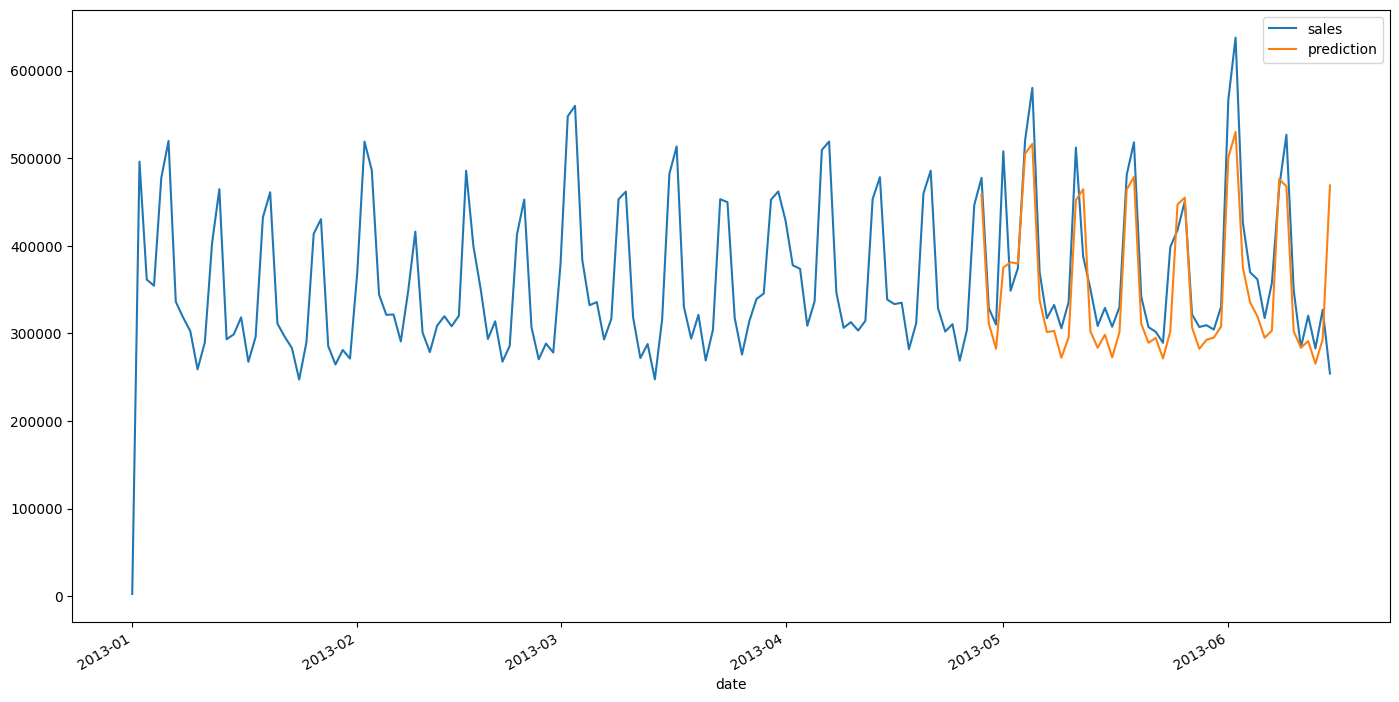

In [621]:
df_all[['sales','prediction']].plot(figsize=(17, 9));

Видно, что модель уловила закономерности.

In [622]:
# Выведем ошибки.
print('MSE', mean_squared_error(y_test, df_test['prediction']))
print('MAE', mean_absolute_error(y_test, df_test['prediction']))
print('MAPE', mean_absolute_percentage_error(y_test, df_test['prediction']))

MSE 2786388237.3831873
MAE 38137.71281
MAPE 0.10250190788508384


### Прогнозирование временных рядов с использованием CatBoost

In [623]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

In [624]:
df_test['prediction_catboost'] = cbr.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

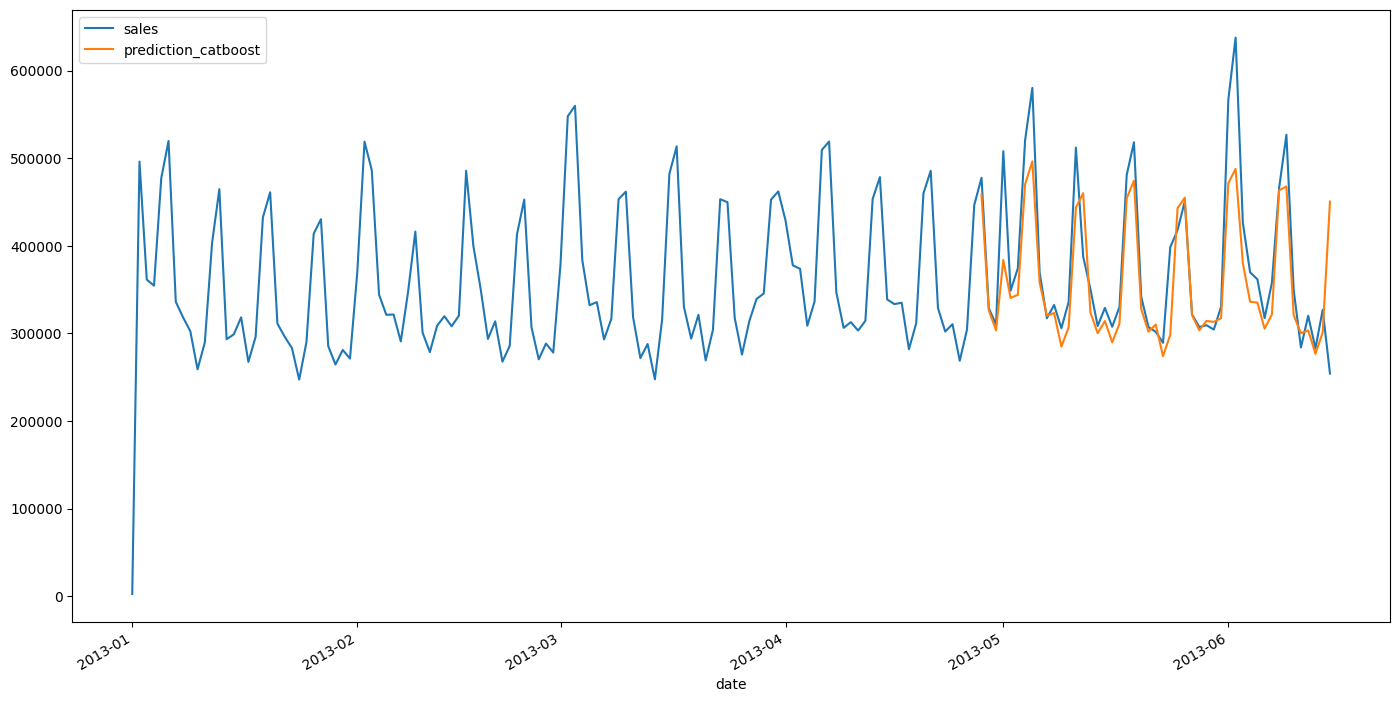

In [625]:
df_all[['sales','prediction_catboost']].plot(figsize=(17, 9));

In [626]:
# Выведем ошибки.
print('MSE', mean_squared_error(y_test, df_test['prediction_catboost']))
print('MAE', mean_absolute_error(y_test, df_test['prediction_catboost']))
print('MAPE', mean_absolute_percentage_error(y_test, df_test['prediction_catboost']))

MSE 2694018752.2804165
MAE 33075.771767658225
MAPE 0.08331889544861783


Ошибка еще снизилась.

### Дополнительные признаки

In [627]:
# Групируем данные.
df = train.groupby('date')['unit_sales'].sum()
# Переводим серию в dataframe.
df = df.to_frame(name='sales')
# Переводим индех в datetime.
df.index = pd.to_datetime(df.index)

In [628]:
# Получите лаговые факторы с 7-го по 10-й предыдущих дней.
for i in range(7, 11):
  df[f'lag_{i}'] = group_train['sales'].shift(i)
df.dropna(inplace=True)

In [629]:
# df = df.reset_index()
# df

In [630]:
# Получим даты праздников за 2013 год из выборки.
us_holidays = []
for date in hd.US(years=2013).items():
  us_holidays.append(str(date[0]))
print(us_holidays)


['2013-01-21', '2013-02-18', '2013-10-14', '2013-01-01', '2013-05-27', '2013-07-04', '2013-09-02', '2013-11-11', '2013-11-28', '2013-12-25']


In [631]:
# Создадим бинарный признак наличия в эту дату праздника.
df['availability_holidays'] = None
for ind in df.index:
  if str(ind).split()[0] in us_holidays:
    df['availability_holidays'].loc[ind] = 1
  else:
    df['availability_holidays'].loc[ind] = 0
df['availability_holidays'] = df['availability_holidays'].astype(int)
print(df['availability_holidays'].unique())

[0 1]


In [632]:
display(df.head())

,sales,lag_7,lag_8,lag_9,lag_10,availability_holidays
date,,,,,,
2013-01-11,289737.685,354459.677,361429.231,496092.418,2511.619,0
2013-01-12,403257.212,477350.121,354459.677,361429.231,496092.418,0
2013-01-13,464638.548,519695.401,477350.121,354459.677,361429.231,0
2013-01-14,293328.362,336122.801,519695.401,477350.121,354459.677,0
2013-01-15,298969.550,318347.778,336122.801,519695.401,477350.121,0


In [633]:
# Разобьем на тренировочную и тестовую выборки.
split_date = '2013-05-3'
df_train = df[df.index <= split_date]
df_test = df[df.index >= split_date]
print(df_train.shape, df_test.shape, sep='\n')

(113, 6)
(44, 6)


In [634]:
def create_features(df, label=None):
    """Создаем признаки из datetime индекса."""

    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['dayofyear'] = df['date'].dt.dayofyear

    X = df[['dayofweek','quarter','month', 'dayofmonth',
            'weekofyear', 'dayofyear', 'lag_7', 'lag_8',
            'lag_9', 'lag_10', 'availability_holidays']]
    if label:
        y = df[label]
        return X, y
    return X

In [635]:
X_train, y_train = create_features(df_train, label='sales')
X_test, y_test = create_features(df_test, label='sales')

In [636]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(113, 11) (113,)
(44, 11) (44,)


### XGBoost

In [637]:
# Создадим модель XGBRegressor.
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

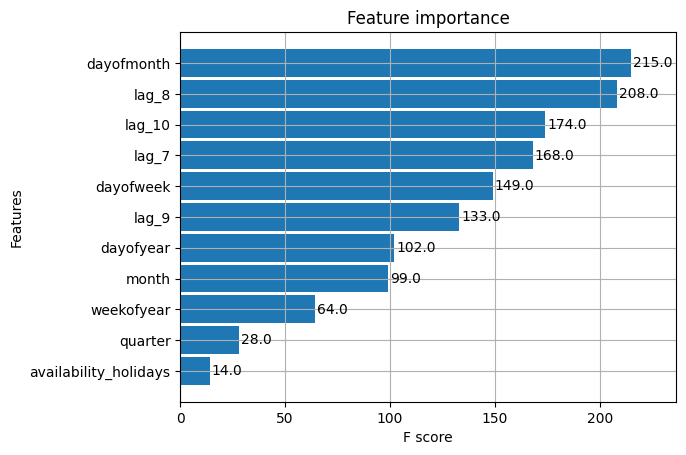

In [638]:
# Выведем важность признаков.
plot_importance(reg, height=0.9);

In [639]:
# Сделаем предсказание.
df_test['prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

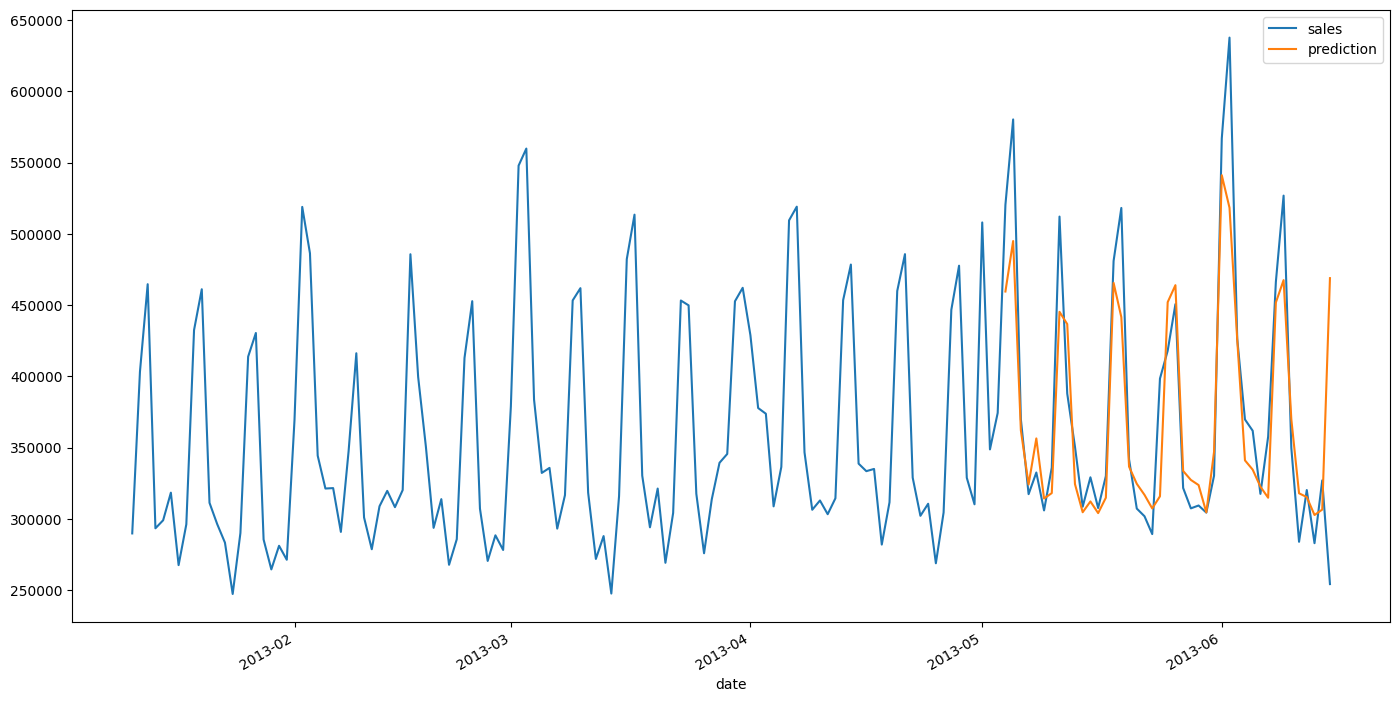

In [640]:
df_all[['sales','prediction']].plot(figsize=(17, 9));

In [641]:
# Выведем ошибки.
print('MSE', mean_squared_error(y_test, df_test['prediction']))
print('MAE', mean_absolute_error(y_test, df_test['prediction']))
print('MAPE', mean_absolute_percentage_error(y_test, df_test['prediction']))

MSE 2429843265.5903797
MAE 31258.281607954545
MAPE 0.08279010242387025


Метрика немного улучшилась.

In [642]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

### CatBoost

In [643]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

In [644]:
df_test['prediction_catboost'] = cbr.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

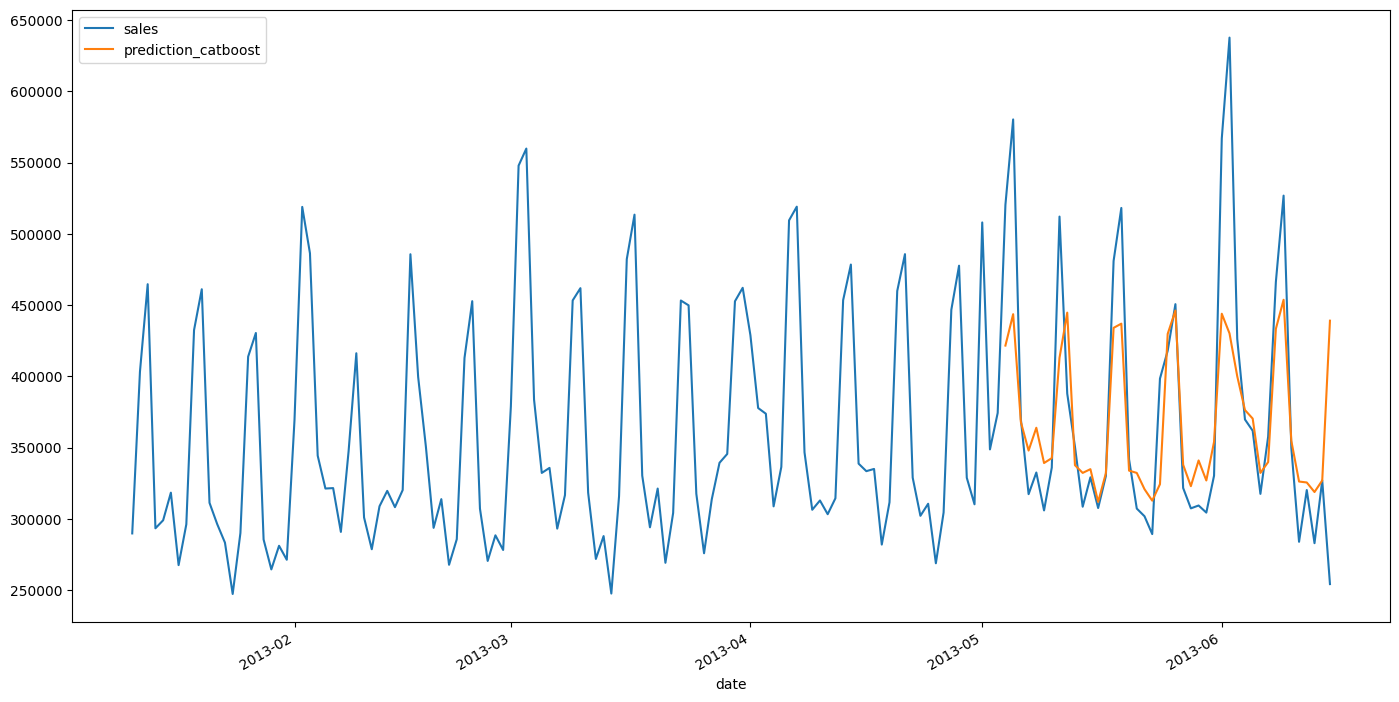

In [645]:
df_all[['sales','prediction_catboost']].plot(figsize=(17, 9));

In [646]:
# Выведем ошибки.
print('MSE', mean_squared_error(y_test, df_test['prediction_catboost']))
print('MAE', mean_absolute_error(y_test, df_test['prediction_catboost']))
print('MAPE', mean_absolute_percentage_error(y_test, df_test['prediction_catboost']))

MSE 3801910825.21217
MAE 39390.96093549315
MAPE 0.0979008467272095


А здесь метрика снизилась.

Дополнительные признаки улучшили предсказательную способность модели построенной на XGBoost.